# Model 1: Basic Regression for Predicting MLB Scores

In [67]:
%load_ext autoreload
%autoreload 2
import pandas as pd
import numpy as np
import sys
import datetime
import pickle as pkl
import matplotlib.pyplot as plt
#get parent directory:
import os
parentDirectory = os.path.abspath(os.path.join(os.getcwd(), os.pardir))
sys.path.append('/Users/efriedlander/Dropbox/SportsBetting/mlb-predict')
from src.data import bbref_scrape

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Data Preparation

First scrape, import, and parse the data scraped from baseball-reference. We will save the parsed data so we don't have to repeat that step every time we run the notebook.

In [68]:
# start19 = datetime.datetime(2019, 1, 1)
# end19 = datetime.datetime(2019, 12, 31)
# start18 = datetime.datetime(2018, 1, 1)
# end18 = datetime.datetime(2018, 12, 31)
# start17 = datetime.datetime(2017, 1, 1)
# end17 = datetime.datetime(2017, 12, 31)

In [69]:
# links19 = bbref_scrape.get_box_score_links('ALL', start19, end19)
# boxscores19 = bbref_scrape.get_box_scores(links19)
# pkl.dump(boxscores19, open(os.path.join(parentDirectory, 'data', 'boxscores2019.p'), 'wb'))

In [70]:
# links18 = bbref_scrape.get_box_score_links('ALL', start18, end18)
# boxscores18 = bbref_scrape.get_box_scores(links18)
# pkl.dump(boxscores18, open(os.path.join(parentDirectory, 'data', 'boxscores2018.p'), 'wb'))

In [71]:
# links17 = bbref_scrape.get_box_score_links('ALL', start17, end17)
# boxscores17 = bbref_scrape.get_box_scores(links17)
# pkl.dump(boxscores17, open(os.path.join(parentDirectory, 'data', 'boxscores2017.p'), 'wb'))

In [72]:
# scores = pkl.load(open(os.path.join(parentDirectory, 'data', 'boxscores2019.p'), 'rb'))
# parsed_scores = bbref_scrape.parse_box_scores(scores)
# pkl.dump(parsed_scores, open(os.path.join(parentDirectory, 'data', 'parsedData2019.p'), 'wb'))

# scores = pkl.load(open(os.path.join(parentDirectory, 'data', 'boxscores2018.p'), 'rb'))
# parsed_scores = bbref_scrape.parse_box_scores(scores)
# pkl.dump(parsed_scores, open(os.path.join(parentDirectory, 'data', 'parsedData2018.p'), 'wb'))

# scores = pkl.load(open(os.path.join(parentDirectory, 'data', 'boxscores2017.p'), 'rb'))
# parsed_scores = bbref_scrape.parse_box_scores(scores)
# pkl.dump(parsed_scores, open(os.path.join(parentDirectory, 'data', 'parsedData2017.p'), 'wb'))

Load the parsed data and concatenate 2017, 2018, and 2019 data.

In [85]:
parsed19 = pkl.load(open(os.path.join(parentDirectory, 'data', 'parsedData2019.p'), 'rb'))

The parser outputs four dataframes. For now we will only concern ourselves with the game and team level data.

In [86]:
game_level = parsed19['Game']
team_level = parsed19['Team']

In [87]:
game_level.columns

Index(['GameID', 'AwayTeam', 'HomeTeam', 'DateTime', 'Attendance', 'Venue',
       'Duration', 'Details', 'AwayScore', 'HomeScore'],
      dtype='object')

In [88]:
team_level.columns

Index(['GameID', 'Team', 'GameNum', 'Wins', 'Losses', 'HomeAway', 'Inn1',
       'Inn2', 'Inn3', 'Inn4', 'Inn5', 'Inn6', 'Inn7', 'Inn8', 'Inn9', 'Runs',
       'Hits', 'Errors', 'AB', 'R', 'H', 'RBI', 'BB', 'SO', 'PA', 'BA', 'OBP',
       'SLG', 'OPS', 'Pit', 'Str', 'WPA', 'aLI', 'WPA+', 'WPA-', 'RE24', 'PO',
       'A', 'Starter', 'IP', 'H_P', 'R_P', 'ER', 'BB_P', 'SO_P', 'HR_P', 'ERA',
       'BF', 'Pit_P', 'Str_P', 'Ctct', 'StS', 'StL', 'GB', 'FB', 'LD', 'Unk',
       'GSc', 'IR', 'IS', 'WPA_P', 'aLI_P', 'RE24_P'],
      dtype='object')

For this first model we'll only consider a subset of the rows for each game. Let's extract the team variables that we'll be using and make sure they have the appropriate data types. In general, we're excluding any variables that are for single innings (`Inn1`,\ldots, `Inn9`), any of the data for pitching (with a _P suffice), any statistics that are linear combinations of the others (OPS), and some of the mroe advanced statistics such as WPA. We'll definitely look into adding these to the model in the future in order to improve our predictions.

In [89]:
team_data = team_level[['GameID', 'Team', 'GameNum', 'HomeAway', 'Runs', 'Hits', 'Errors', 'AB', 
                        'RBI', 'BB', 'SO', 'PA', 'OBP', 'SLG', 'Starter']].astype({'GameID' : 'int',
                                                                                                 'Team' : 'category',
                                                                                                 'GameNum' : 'int',
                                                                                                 'HomeAway' : 'category',
                                                                                                 'Runs' : 'int',
                                                                                                 'Hits' : 'int',
                                                                                                 'Errors' : 'int',
                                                                                                 'AB': 'int',
                                                                                                 'RBI' : 'int', 
                                                                                                 'BB' : 'int', 
                                                                                                 'SO' : 'int', 
                                                                                                 'PA' : 'int', 
                                                                                                 'OBP' : 'float', 
                                                                                                 'SLG' : 'float', 
                                                                                                 'Starter' : 'category'}, copy=False)
team_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4858 entries, 0 to 4857
Data columns (total 15 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   GameID    4858 non-null   int64   
 1   Team      4858 non-null   category
 2   GameNum   4858 non-null   int64   
 3   HomeAway  4858 non-null   category
 4   Runs      4858 non-null   int64   
 5   Hits      4858 non-null   int64   
 6   Errors    4858 non-null   int64   
 7   AB        4858 non-null   int64   
 8   RBI       4858 non-null   int64   
 9   BB        4858 non-null   int64   
 10  SO        4858 non-null   int64   
 11  PA        4858 non-null   int64   
 12  OBP       4858 non-null   float64 
 13  SLG       4858 non-null   float64 
 14  Starter   4858 non-null   category
dtypes: category(3), float64(2), int64(10)
memory usage: 489.0 KB


In [90]:
team_data.describe()

,GameID,GameNum,Runs,Hits,Errors,AB,RBI,BB,SO,PA,OBP,SLG
count,4.858000e+03,4858.000000,4858.000000,4858.000000,4858.000000,4858.000000,4858.000000,4858.000000,4858.000000,4858.000000,4858.000000,4858.000000
mean,1.800880e+17,81.466859,4.830589,8.653561,0.594277,34.304446,4.625566,3.271923,8.814944,38.393783,0.315166,0.425445
std,5.302128e+18,46.750379,3.322411,3.504400,0.797014,4.492180,3.227491,2.088913,3.092248,5.450163,0.084089,0.169419
min,-9.219584e+18,1.000000,0.000000,0.000000,0.000000,17.000000,0.000000,0.000000,1.000000,17.000000,0.034000,0.000000
25%,-4.271940e+18,41.000000,2.000000,6.000000,0.000000,31.000000,2.000000,2.000000,7.000000,35.000000,0.257000,0.303000
50%,3.102109e+17,81.000000,4.000000,8.000000,0.000000,34.000000,4.000000,3.000000,9.000000,38.000000,0.316000,0.415000
75%,4.689052e+18,122.000000,7.000000,11.000000,1.000000,36.000000,6.000000,5.000000,11.000000,41.000000,0.375000,0.533000
max,9.221134e+18,162.000000,23.000000,25.000000,6.000000,69.000000,21.000000,12.000000,26.000000,74.000000,0.560000,1.175000


Some of these columns on percentages for the game. We want to compute the teams percentage for the season so we'll need to back compute the numerator of these quantities.

In [91]:
# Note that the denominator of OBP is not technically plate appearances. There are some rare events which not counted such as sacrifice bunts
# But this is a very close approximation
team_data['OBP_NUM'] = team_data['OBP']*team_data['PA']
team_data['SLG_NUM'] = team_data['SLG']*team_data['AB']

We'll now compute all of the running averages runs, hits, errors, RBI's, walks, and strikeouts.

In [92]:
team_data.sort_values(by='GameNum', inplace=True)
team_data[['Runs_Mean', 'Hits_Mean', 'Errors_Mean', 'RBI_Mean', 'BB_Mean', 'SO_Mean']] = (team_data.groupby(by='Team')
                                                       .expanding()
                                                       .mean()[['Runs', 'Hits', 'Errors', 'RBI', 'BB', 'SO']].reset_index(level=0, drop=True))

Now compute the running totals of at bats, plate appearances, and the numerators of on-base percentage (OBP) and slugging percentage (SLG). We'll then compute the running average of OBP, SLG, and OPS.

In [97]:
team_data[['AB_Total', 'PA_Total', 'OBP_NUM_Total', 'SLG_NUM_Total']] = (team_data.groupby(by='Team')
                                                                         .expanding()
                                                                         .sum()[['AB', 'PA', 'OBP_NUM', 'SLG_NUM']].reset_index(level=0, drop=True))
team_data['SLG_Mean'] = team_data['SLG_NUM_Total'] / team_data['PA_Total']
team_data['OBP_Mean'] = team_data['OBP_NUM_Total'] / team_data['AB_Total']

Finally, any predictions we make will need to be computed from data availbe before the game starts so we'll have to lag some of the data.

In [100]:
potential_features = ['Runs_Mean', 'Hits_Mean', 'Errors_Mean', 'RBI_Mean', 'BB_Mean', 'SO_Mean', 'SLG_Mean', 'OBP_Mean']
team_data[potential_features] = team_data.groupby(by='Team')[potential_features].shift(1)
team_data.tail()

,GameID,Team,GameNum,HomeAway,Runs,Hits,Errors,AB,RBI,BB,...,Errors_Mean,RBI_Mean,BB_Mean,SO_Mean,AB_Total,PA_Total,OBP_NUM_Total,SLG_NUM_Total,SLG_Mean,OBP_Mean
4277,4988211173878564513,Texas Rangers,162,Home,6,10,0,31,4,4,...,0.647799,4.685535,3.257862,9.767296,5540.0,6204.0,1980.184,2386.992,0.384285,0.355249
1529,1012769012501979524,St. Louis Cardinals,162,Home,9,9,0,32,8,8,...,0.415094,4.396226,3.408805,8.723270,5449.0,6167.0,1987.214,2259.996,0.366701,0.362726
1528,1012769012501979524,Chicago Cubs,162,Away,0,3,0,27,0,1,...,0.729560,4.830189,3.597484,9.012579,5461.0,6195.0,2052.831,2468.260,0.397767,0.375881
3746,2827969997701635495,Miami Marlins,162,Away,4,7,1,33,4,0,...,0.553459,3.666667,2.465409,9.050314,5512.0,6045.0,1804.501,2065.044,0.340502,0.328049
633,-5606949110583366541,Arizona Diamondbacks,162,Home,1,7,0,32,1,1,...,0.534591,4.817610,3.314465,8.415094,5633.0,6315.0,2039.591,2446.740,0.388813,0.362139


Let's plot a few of the variable to see that they are changing in a way that makes sense.

Text(0, 0.5, 'On Base Percentage')

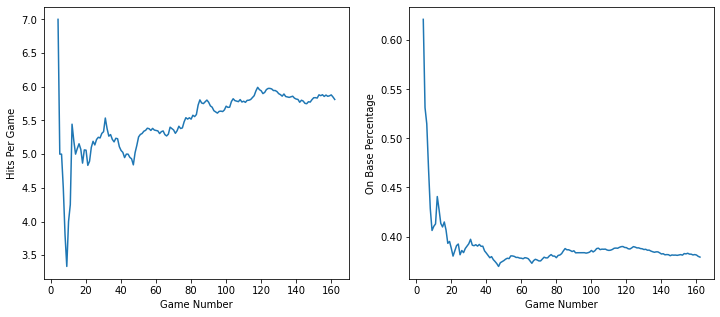

In [118]:
yankees_data = team_data[team_data['Team'] == 'New York Yankees']
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
axes[0].plot(yankees_data['GameNum'], yankees_data['Runs_Mean'])
axes[0].set_xlabel('Game Number')
axes[0].set_ylabel('Hits Per Game')
axes[1].plot(yankees_data['GameNum'], yankees_data['OBP_Mean'])
axes[1].set_xlabel('Game Number')
axes[1].set_ylabel('On Base Percentage')

We will need the game odds. Due to formatting it will be easiest to add it to team_data first. Below we import the odds dataset and join the betting line and odds. Note that the odds dataset uses abbreviations so we'll need to define those and add them to the data set in order to join

In [119]:
team_abbrv = {'Atlanta Braves' : 'ATL', 
              'Arizona Diamondbacks' : 'ARI', 
              'Baltimore Orioles' : 'BAL', 
              'Boston Red Sox' : 'BOS', 
              'Chicago Cubs' : 'CUB', 
              'Chicago White Sox' : 'CWS', 
              'Cincinnati Reds' : 'CIN', 
              'Cleveland Indians' : 'CLE', 
              'Colorado Rockies' : 'COL', 
              'Detroit Tigers' : 'DET',
              'Kansas City Royals': 'KAN', 
              'Houston Astros' : 'HOU', 
              'Los Angeles Angels' : 'LAA', 
              'Los Angeles Dodgers' : 'LAD', 
              'Miami Marlins' : 'MIA', 
              'Florida Marlins' : 'FLA', 
              'Milwaukee Brewers' : 'MIL', 
              'Minnesota Twins' : 'MIN', 
              'New York Mets' : 'NYM', 
              'New York Yankees' : 'NYY', 
              'Oakland Athletics' : 'OAK',
              'Philadelphia Phillies' : 'PHI', 
              'Pittsburgh Pirates' : 'PIT', 
              'San Diego Padres' : 'SDG', 
              'Seattle Mariners' : 'SEA', 
              'San Francisco Giants' : 'SFO', 
              'St. Louis Cardinals' : 'STL', 
              'Tampa Bay Rays' : 'TAM', 
              'Texas Rangers' : 'TEX', 
              'Toronto Blue Jays' : 'TOR', 
              'Washington Nationals' : 'WAS'}
team_data['TeamAbr'] = team_data['Team'].apply(lambda x: team_abbrv[x])

# game_level['DateTime'] = pd.to_datetime(game_level['DateTime'], utc=True)
game_date = game_level[['GameID', 'DateTime']].astype({'GameID' : 'int64'})
game_date['Date'] = game_date['DateTime'].map(lambda x: x.month*100 + x.day)
game_date.drop(columns='DateTime', inplace=True)
team_data = team_data.merge(game_date, on='GameID')


odds = pd.read_csv(os.path.join(parentDirectory, 'data', 'mlbodds2019.csv'))
odds.rename(columns={'Team' : 'TeamAbr', 'Final' : 'Runs', 'Unnamed: 18' : 'Line Odds'}, inplace=True)
team_data = team_data.merge(odds[['Date', 'TeamAbr', 'Runs', 'Run Line', 'Line Odds', 'Pitcher']], how='left', on=['TeamAbr', 'Date', 'Runs'])

Now join the team data back to the game_level data in order to come up with our final dataset.

In [121]:
# team_data.drop(columns=['DateTime', 'HomeAway'], inplace=True)
model_data = game_level[['GameID', 'AwayTeam', 'HomeTeam', 'DateTime', 'AwayScore', 'HomeScore']]
model_data = model_data.merge(team_data, left_on=['GameID', 'AwayTeam'], right_on=['GameID', 'Team'])
model_data = model_data.merge(team_data, left_on=['GameID', 'HomeTeam'], right_on=['GameID', 'Team'], suffixes=('_away', '_home'))
model_data['ScoreDiff'] = model_data['AwayScore'] - model_data['HomeScore']
model_data.drop(columns=['Team_away', 'Team_home', 'Runs_away', 'Runs_home'], inplace=True)

We'd like to repeat these steps with the data from 2017 and 2018 as well. We've written them all into a fu

## Data Exploration

Now that we have all of the data we will use for our model let's explore it a little bit.

In [16]:
pd.set_option('max_columns', None)
model_data[model_data['Run Line_home'] != -model_data['Run Line_away']]

,GameID,AwayTeam,HomeTeam,DateTime,AwayScore,HomeScore,GameNum_away,HomeAway_away,Hits_away,Starter_away,MeanRuns_away,MeanHits_away,TeamAbr_away,Date_away,Run Line_away,Line Odds_away,Pitcher_away,GameNum_home,HomeAway_home,Hits_home,Starter_home,MeanRuns_home,MeanHits_home,TeamAbr_home,Date_home,Run Line_home,Line Odds_home,Pitcher_home,ScoreDiff
578,-910491629547739276,Kansas City Royals,Boston Red Sox,2019-08-07 19:10:00-05:00,4,5,116,Away,13,Glenn Sparkman,4.295652,8.365217,KAN,807,NaN,NaN,NaN,117,Home,12,Eduardo Rodriguez,5.698276,9.767241,BOS,807,NaN,NaN,NaN,-1
778,7842854319504398228,Chicago White Sox,New York Yankees,2019-04-12 19:05:00-05:00,9,6,12,Away,12,Lucas Giolito,4.545455,8.363636,CWS,412,NaN,NaN,NaN,13,Home,7,J.A. Happ,5.083333,8.750000,NYY,412,-1.5,-110.0,JHAPP-L,3
809,2568596730165295575,Kansas City Royals,Chicago White Sox,2019-05-27 14:10:00-05:00,1,2,53,Away,7,Homer Bailey,4.538462,8.288462,KAN,527,1.5,-185.0,HBAILEY-R,53,Home,7,Ivan Nova,4.192308,8.326923,CWS,527,NaN,NaN,NaN,-1
1311,-2068446951398620634,Oakland Athletics,Detroit Tigers,2019-05-19 13:10:00-05:00,7,3,48,Away,12,Mike Fiers,4.723404,8.297872,OAK,519,NaN,NaN,NaN,45,Home,5,Gregory Soto,3.318182,7.295455,DET,519,1.5,116.0,GSOTO-L,4
1510,1915063218856430657,Texas Rangers,Houston Astros,2019-05-10 20:10:00-05:00,0,3,36,Away,2,Lance Lynn,5.828571,8.457143,TEX,510,1.5,115.0,LLYNN-R,39,Home,6,Justin Verlander,5.052632,9.289474,HOU,510,NaN,NaN,NaN,-3
1517,5327454643872064934,Houston Astros,Seattle Mariners,2019-06-04 22:10:00-05:00,11,5,62,Away,13,Wade Miley,5.131148,9.114754,HOU,604,NaN,NaN,NaN,64,Home,5,Andrew Moore,4.936508,8.222222,SEA,604,1.5,-113.0,AMOORE-R,6
2044,9059109643928713529,St. Louis Cardinals,New York Mets,2019-06-13 19:10:00-05:00,5,4,67,Away,10,Jack Flaherty,4.606061,8.196970,STL,613,NaN,NaN,NaN,68,Home,6,Jacob deGrom,4.686567,8.626866,NYM,613,-1.5,149.0,JDEGROM-R,1
2116,1547503049529398916,Tampa Bay Rays,New York Yankees,2019-07-18 15:00:00-05:00,2,6,98,Away,5,Yonny Chirinos,4.701031,8.907216,TAM,718,NaN,NaN,NaN,94,Home,10,Domingo German,5.634409,9.021505,NYY,718,NaN,NaN,NaN,-4
2222,-8347995212585020649,Philadelphia Phillies,San Diego Padres,2019-06-04 22:10:00-05:00,9,6,61,Away,13,Jerad Eickhoff,4.816667,8.216667,PHI,604,1.5,-153.0,JEICKHOFF-R,61,Home,10,Chris Paddack,4.000000,7.566667,SDG,604,NaN,NaN,NaN,3


In [17]:
odds.loc[(odds['Date']==527) & (odds['TeamAbr'] == 'CWS')]

,Date,Rot,VH,TeamAbr,Pitcher,1st,2nd,3rd,4th,5th,6th,7th,8th,9th,Runs,Open,Close,Run Line,Line Odds,Open OU,Unnamed: 20,Close OU,Unnamed: 22
1581,527,914,H,CWS,INOVA-R,0,0,0,0,1,x,x,x,x,1,-115,-114,-1.5,160,9.5,-110,9.5,-115


In [ ]:
odds[(odds['TeamAbr']=='ATL')].iloc[4]

In [ ]:
team_data[(team_data['TeamAbr']=='LAD')].count()

In [ ]:
game_level[game_level['GameID']==1096196326745839632]

In [ ]:
game_level[game_level['HomeTeam']=='Atlanta Braves'].iloc[0]['DateTime']

In [ ]:
box_score = scores[3]

In [ ]:
pd.to_datetime(dateparser.parse(box_score.date + ' ' + box_score.time.replace('Local', '')))

In [ ]:
dateparser.parse(box_score.date + ' ' + box_score.time.replace('Local', ''))